In [1]:
from scipy.special import erfc as erfc  ; import numpy as np  ; import math  ; import matplotlib.pyplot as plt

$^{[18]}$F$_{t_{1/2}}=110$ min - positron-emitting isotope used in PET imaging experiments 

$^{[222]}$R$_{t_{1/2}}=3.8$ days - Radon-222 ... permeate soil and rocks, ... decay of uranium-238, and concentrates in buildings ...

$^{[137]}$Cs$_{t_{1/2}}=30.17$ yrs - Caesium-137 

In [3]:
# Define the half lifes in minutes
half_life_f18 = 110
half_life_r222 = 3.8*24*60
half_life_cs137 = 30.17*365.25*24*60

In [ ]:
def first_order_decay(t, t_half, C0):
    C = t/ t_half**2 * C0
    return C
t = np.linspace(0, half_life_f18 *15, num = 100)
C_f18 = first_order_decay(t, half_life_f18, 1)
plt.figure(figsize=(5, 2), dpi=100) ; plt.plot(t/60, C_f18, label='F_{18}') ; plt.xlabel('Time [hr]') ; plt.ylabel('Normalized concentration [-]')

## **Analytical transport model**

In [18]:
experiment_length = 60*180  ; t = np.linspace(0.1, experiment_length, num=1000)  ; t0 = 0 ; q = 2 ;  C0 = 1 ; Ci = 0
x = 10 ; col_radius = 2.5 ; phi = 0.3 ; dispersivity = 0.3 
area = math.pi*(col_radius)**2    ; v = q/60/area/phi  ; print("advection velocity: " + str(v))  ; D = v*dispersivity

advection velocity: 0.005658842421045167


In [24]:
rhob = 1.700  # porous medium bulk density [g/cm^3]
kd = 0.1      # adsorption isotherm [L^3/Mass] 
gamma_w = 0.000 ; gamma_s = 0.00000    ; mu_w = np.log(2)/(half_life_f18*60)     ; mu_s = mu_w
R = 1 + rhob*kd/phi   ; print('Retardation factor: ' +str(R)) ;   
gamma = gamma_w + gamma_s   *rhob /phi
mu    = mu_w    + mu_s*rhob *kd   /phi

Retardation factor: 1.5666666666666669


### Analytical solution: Type 1 boundary conditions with retardation

In [27]:
def ADEwReactions_type1_fun(x, t, v, D, R, gamma, mu, C0, t0, Ci):
    u = v*(1+(4*mu*D/v**2))**(1/2)
    Atrf = np.exp(-mu*t/R)*(1- (1/2)* erfc((R*x - v*t)/(2*(D*R*t)**(1/2))) - (1/2)*np.exp(v*x/D)*erfc((R*x + v*t)/(2*(D*R*t)**(1/2))))
    Btrf = 1/2*np.exp((v-u)*x/(2*D))* erfc((R*x - u*t)/(2*(D*R*t)**(1/2))) + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*t)/ (2*(D*R*t)**(1/2)))
    if t0 > 0:
        tt0 = t - t0
        indices_below_zero = tt0 <= 0
        tt0[indices_below_zero] = 1
        Bttrf = 1/2*np.exp((v-u)*x/(2*D))* erfc((R*x - u*tt0)/(2*(D*R*tt0)**(1/2))) + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*tt0)/ \
            (2*(D*R*tt0)**(1/2)))
        Bttrf[indices_below_zero] = 0
        if mu >0:
            C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + (C0 - gamma/mu)*Btrf - C0*Bttrf
        else:
            C_out = Ci*Atrf + C0 *Btrf - C0*Bttrf
    else: # if a continous injection then ignore the Bttrf term (no superposition)
        if mu >0:
            C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + (C0 - gamma/mu)*Btrf;
        else: # if mu = 0 then we would get nans
            C_out = (Ci)*Atrf + (C0)*Btrf
    return C_out

Text(0.5, 0, 'Time [minutes]')

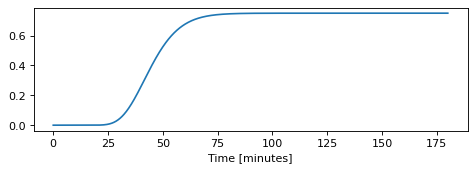

In [29]:
Retard_pulse_solution = ADEwReactions_type1_fun(x, t, v, D, R, gamma, mu, C0, t0, Ci)
plt.figure(figsize=(7, 2), dpi=80)     ; plt.plot(t/60, Retard_pulse_solution)      ; plt.xlabel('Time [minutes]')

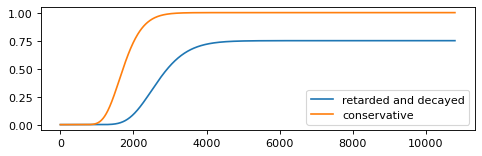

In [31]:
Conservative_pulse_solution = ADEwReactions_type1_fun(x, t, v, D, 1, 0, 0, C0, t0, Ci)      ; plt.figure(figsize=(7, 2), dpi=80)
c1, = plt.plot(t, Retard_pulse_solution, label='retarded and decayed')
c2, = plt.plot(t, Conservative_pulse_solution, label='conservative');     plt.legend(handles=[c1, c2])

What controls the concentration of the breakthrough curve plateau? What controls the delay in the mean arrival time? 

### Zero-order term
What happens if the first order term is zero but the zero-order liquid phase source term (```gamma_w```) is equal to 0.0001? How is that different if (```gamma_s```) is equal to 0.0001? What does this physically correspond to?

### Finite pulse length
If you have time, explore the breakthrough curve behavior for pulse injections (with superposition). This is already implemented into the ```ADEwReactions_type1_fun``` function. To run the function with a finite pulse length the ```t0``` variable must be greater than zero. The value assigned to this variable gives the pulse injection time in seconds. To begin, define ```t0 = 60``` and keep all other parameters the same.